# Protein Secondary Structure Prediction

In [148]:
#!wget -c -P data http://www.princeton.edu/~jzthree/datasets/ICML2014/cullpdb+profile_5926_filtered.npy.gz
#!wget -c -P data http://www.princeton.edu/~jzthree/datasets/ICML2014/cb513+profile_split1.npy.gz

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import timeit
import os

In [7]:
train_path = 'cullpdb+profile_5926_filtered.npy.gz'
test_path = 'cb513+profile_split1.npy.gz'

In [8]:
AA = ['A', 'C', 'E', 'D', 'G', 'F', 'I', 'H', 'K', 'M', 'L', 'N', 'Q', 'P', 'S', 'R', 'T', 'W', 'V', 'Y', 'X', 'NoSeq']
SS = ['L', 'B', 'E', 'G', 'I', 'H', 'S', 'T', 'NoSeq']

In [9]:
def load(path):
    data = np.load(f'data/{path}')
    
    # Original 57 features.
    data = data.reshape(-1, 700, 57)

    # 20-residues and a non-seq.
    X = data[:, :, np.arange(21)]
    X = X.transpose(0, 2, 1)
    X = X.astype('float32')

    # 8-states.
    y = data[:, :, 22:30]
    y = np.array([np.dot(yi, np.arange(8)) for yi in y])
    y = y.astype('float32')
    
    mask = data[:, :, 30] * -1 + 1
    seq_len = mask.sum(axis=1)
    seq_len = seq_len.astype('int')
    
    return X, y, seq_len

In [10]:
# Loading data.
train_X, train_y, train_seq_len = load(train_path)
print(f'Training set {len(train_seq_len)} sequences.')

test_X, test_y, test_seq_len = load(test_path)
print(f'Test set {len(test_seq_len)} sequences.')

Training set 5365 sequences.
Test set 514 sequences.


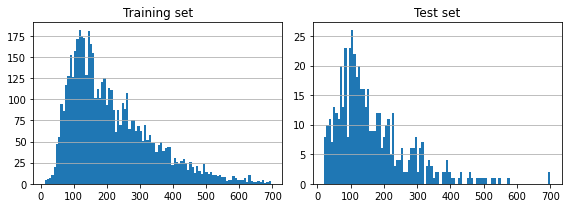

In [138]:
# Sequence Length.
plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.title('Training set')
plt.hist(train_seq_len, bins=100)
plt.grid(True, axis='y')

plt.subplot(1, 2, 2)
plt.title('Test set')
plt.hist(test_seq_len, bins=100)
plt.grid(True, axis='y')

plt.tight_layout()
plt.savefig('figure/seq_len.png', dpi=100)

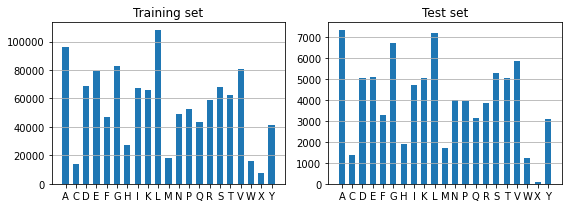

In [142]:
# Amino Acid Residues.
train_aa = []
train_count = []
for seq, seq_len in zip(train_X, train_seq_len):
    seq_aa = []
    for aa in seq[:, :seq_len].T:
        assert len(np.where(aa == 1)) == 1
        seq_aa.append(AA[aa.argmax()])
    train_aa += seq_aa

train_aa = pd.DataFrame(train_aa, columns=['AA'])
train_aa = train_aa.groupby('AA').aggregate(count=('AA', 'size'))

test_aa = []
test_count = []
for seq, seq_len in zip(test_X, test_seq_len):
    seq_aa = []
    for aa in seq[:, :seq_len].T:
        assert len(np.where(aa == 1)) == 1
        seq_aa.append(AA[aa.argmax()])
    test_aa += seq_aa
    
test_aa = pd.DataFrame(test_aa, columns=['AA'])
test_aa = test_aa.groupby('AA').aggregate(count=('AA', 'size'))

plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.title('Training set')
plt.bar(train_aa.index, train_aa['count'], width=0.6)
plt.grid(True, axis='y')

plt.subplot(1, 2, 2)
plt.title('Test set')
plt.bar(test_aa.index, test_aa['count'], width=0.6)
plt.grid(True, axis='y')

plt.tight_layout()
plt.savefig('figure/amino_acid.png', dpi=100)

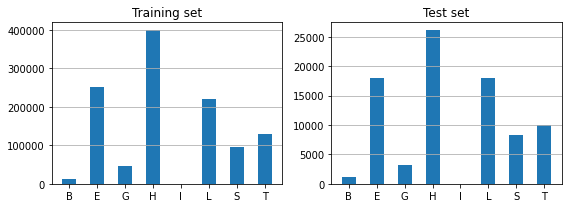

In [146]:
# 8-states Secondary Structures.
train_ss = []
for seq, seq_len in zip(train_y, train_seq_len):
    seq_ss = []
    for ss in seq[:seq_len]:
        seq_ss += SS[int(ss)]
    train_ss += seq_ss

train_ss = pd.DataFrame(train_ss, columns=['SS'])
train_ss = train_ss.groupby('SS').aggregate(count=('SS', 'size'))

test_ss = []
for seq, seq_len in zip(test_y, test_seq_len):
    seq_ss = []
    for ss in seq[:seq_len]:
        seq_ss += SS[int(ss)]
    test_ss += seq_ss

test_ss = pd.DataFrame(test_ss, columns=['SS'])
test_ss = test_ss.groupby('SS').aggregate(count=('SS', 'size'))

plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.title('Training set')
plt.bar(train_ss.index, train_ss['count'], width=0.5)
plt.grid(True, axis='y')

plt.subplot(1, 2, 2)
plt.title('Test set')
plt.bar(test_ss.index, test_ss['count'], width=0.5)
plt.grid(True, axis='y')

plt.tight_layout()
plt.savefig('figure/ss.png')